# SkillupAI ML東京20期 通し課題 Day2_work_村井智哉

- データセット名  Kickstarter Projects
- URL https://www.kaggle.com/kemical/kickstarter-projects

### もくじ
1. ライブラリの読み込み  
2. データの読み込み  
3. データ各項目の確認  
　3.1 データ全体  
　3.2 各項目  
4. 数値項目間の関係  
　4.1 要約統計量  
　4.2 相関係数  
　4.3 ヒートマップ  
5. stateと数値項目の関係  
6. ダミー変数化  
7. ロジスティック回帰  
  
～～～～～～～～～～～～～～～  
8. 線形回帰とホールドアウト法  
9. 線形回帰と交差検証法  
10. 項目9に白色化を組み込む  

## 1. ライブラリの読み込み

In [1]:
# %matplotlib notebook
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, confusion_matrix
                                                        # 分類問題の性能評価
from sklearn.linear_model import LinearRegression       # 線形回帰
from sklearn.metrics import mean_absolute_error         # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split    # ホールアウト法
from sklearn.model_selection import KFold               # 交差検証法
from sklearn.preprocessing import MinMaxScaler          # 正規化
from sklearn.decomposition import PCA                   # 主成分分析
from sklearn.preprocessing import StandardScaler        # 標準化

import datetime as dt                                   # 日時を扱う

## 2. データの読み込み

Kickstarter（キックスターター）とは2009年に設立されたアメリカ合衆国の民間営利企業で、自社のウェブサイトにおいてクリエイティブなプロジェクトに向けてクラウドファンディングによる資金調達を行う手段を提供している。

|項目            |種類|内容                  　　　　　　　　　　|
|----------------|----|------------------------------------------|
|ID	             |key |プロジェクトのID　　　　　　　　　　　　　|
|name	         |文字|プロジェクト名　　　　　　　　　　　　　　|
|category	     |文字|詳細なカテゴリー　　　　　　　　　　　　　|
|main_category	 |文字|主なカテゴリー　　　　　　　　　　　　　　|
|currency	     |通貨|使用された通貨　　　　　　　　　　　　　　|
|deadline	     |日付|資金調達の締切日付　　　　　　　　　　　　|
|goal	         |数値|目標調達資金額　　　　　　　　　　　　　　|
|launched	     |日付|資金調達の開始日時　　　　　　　　　　　　|
|pledged	     |数値|集まった資金　　　　　　　　　　■調達結果|
|state	         |文字|プロジェクトの状態　　　　　　　■目的変数|
|backers	     |数値|集まった支援者　　　　　　　　　■調達結果|
|country	     |文字|資金調達を行う国　　　　　　　　　　　　　|
|usd pledged	 |数値|集まった資金の米ドル換算　　　　■調達結果|
|usd_pledged_real|数値|実際に集まった資金の米ドル換算　■調達結果|	
|usd_goal_real   |数値|実際の目標の米ドル換算　　　　　■調達結果|

- 成功の定義：資金調達の開始日時から締切日までに目標調達資金額以上の金額を集めること。
- 課題：プロジェクトが成功するか否かを予測する。■目的変数はstate
- 注意：上記の■調達結果は、プロジェクトが始まる前には知りえない値である。予測するためには使えない値である。
- ■調達結果を用いてロジスティック回帰を行ったところ、accuracy=98%、recall=95%、precision=99%と高すぎる値が得られた。
- ■調達結果を用いずロジスティック回帰を行ったところ、accuracy=98%、recall=55%、precision=41%になった。ネットで探した記事と比べるとaccuracyの値が高すぎるため、計算を再確認する必要がある。

In [2]:
df_ksp = pd.read_csv("./input/ks-projects-201801.csv")

In [3]:
display(df_ksp.head(10))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


## 3. データ各項目の確認

## 3.1 データ全体

In [4]:
# データ全体の行数、列数
print("df_ksp.shape=", df_ksp.shape)

df_ksp.shape= (378661, 15)


In [5]:
# 各項目の行数と型
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## 3.1.1 日時はobject➡datetimeに変換する(変換不可の場合はNA(欠損値)になる)

In [6]:
df_ksp["deadline"] = pd.to_datetime(df_ksp["deadline"], errors = "coerce")
df_ksp["launched"] = pd.to_datetime(df_ksp["launched"], errors = "coerce")

## 3.1.2 欠損値
【対応】欠損値がある行は1%程度のため、行を削除する。

|項目|件数、割合|
|----|----------|
|name|4件÷378661=1.0563538362810007e-05|
|use pledged|3797件÷378661=0.0100274387908974|

In [7]:
# 各項目の欠損値
df_ksp.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [8]:
df_ksp[df_ksp["name"].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,317.73,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,0.0,suspended,0,US,0.00,0.00,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,220.00,35000.00


In [9]:
df_ksp[df_ksp["usd pledged"].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",NaN,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",NaN,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,"N,0""",NaN,1585.00,1200.00


In [10]:
df_ksp = df_ksp.dropna(how="any")

In [11]:
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 15 columns):
ID                  374860 non-null int64
name                374860 non-null object
category            374860 non-null object
main_category       374860 non-null object
currency            374860 non-null object
deadline            374860 non-null datetime64[ns]
goal                374860 non-null float64
launched            374860 non-null datetime64[ns]
pledged             374860 non-null float64
state               374860 non-null object
backers             374860 non-null int64
country             374860 non-null object
usd pledged         374860 non-null float64
usd_pledged_real    374860 non-null float64
usd_goal_real       374860 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(2), object(6)
memory usage: 45.8+ MB


In [12]:
df_ksp.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

## 3.2 各項目

## 3.2.1 項目 state (状態)

|項目        |扱い　内容　　　　　　　          |
|------------|----------------------------------|
|'failed'    |×　　失敗した　　　　　　　　　　|
|'successful'|〇　　成功した　　　　　　　　　　|
|'canceled'  |×　　キャンセル　　　　　　　　　|
|'live'      |×　　生きている　　　　　　　　　|
|'suspended' |×　　中断された　　　　　　　　　|
|'undefined' |―　　未定義(欠損値削除時に削除済)|

In [13]:
# 項目 state の概要確認
df_ksp["state"].value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64

In [14]:
df_ksp.loc[df_ksp["state"] == "failed"    , "state"] = False
df_ksp.loc[df_ksp["state"] == "successful", "state"] = True
df_ksp.loc[df_ksp["state"] == "canceled"  , "state"] = False
df_ksp.loc[df_ksp["state"] == "live"      , "state"] = False
df_ksp.loc[df_ksp["state"] == "suspended" , "state"] = False

In [15]:
df_ksp["state"].unique()

array([False,  True])

## 3.2.2 項目 ID
(1) IDはすべて異なるため、stateとの関係は、特にないと考え、削除する。

In [16]:
# 項目 ID の概要確認
df_ksp["ID"].nunique()

374860

In [17]:
# 項目 ID の概要確認
df_ksp["ID"].unique()

array([1000002330, 1000003930, 1000004038, ...,  999986353,  999987933,
        999988282], dtype=int64)

In [18]:
df_ksp.drop(columns="ID", inplace=True)
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 14 columns):
name                374860 non-null object
category            374860 non-null object
main_category       374860 non-null object
currency            374860 non-null object
deadline            374860 non-null datetime64[ns]
goal                374860 non-null float64
launched            374860 non-null datetime64[ns]
pledged             374860 non-null float64
state               374860 non-null bool
backers             374860 non-null int64
country             374860 non-null object
usd pledged         374860 non-null float64
usd_pledged_real    374860 non-null float64
usd_goal_real       374860 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(5), int64(1), object(5)
memory usage: 40.4+ MB


## 3.2.3 項目 name
(1) 内容は、プロジェクト名である。  
(2) nameは372068種類あり、ほぼすべて異なるため、stateとの関係は、特にないと考え、削除する。

In [19]:
# 項目 name の概要確認
df_ksp["name"].nunique()

372068

In [20]:
df_ksp["name"].unique()

array(['The Songs of Adelaide & Abullah',
       'Greeting From Earth: ZGAC Arts Capsule For ET', 'Where is Hank?',
       ...,
       'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!',
       'BioDefense Education Kit', 'Nou Renmen Ayiti!  We Love Haiti!'],
      dtype=object)

In [21]:
df_ksp.drop(columns="name", inplace=True)
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 13 columns):
category            374860 non-null object
main_category       374860 non-null object
currency            374860 non-null object
deadline            374860 non-null datetime64[ns]
goal                374860 non-null float64
launched            374860 non-null datetime64[ns]
pledged             374860 non-null float64
state               374860 non-null bool
backers             374860 non-null int64
country             374860 non-null object
usd pledged         374860 non-null float64
usd_pledged_real    374860 non-null float64
usd_goal_real       374860 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(5), int64(1), object(4)
memory usage: 37.5+ MB


## 3.2.4 項目 category (詳細なカテゴリー)
(1) 内容は、kickstarterプロジェクトの詳細なカテゴリーであり、159種類がある。  
(2) この上位にあるmain_category(主なカテゴリー)で評価する。categoryは数が多いので評価の対象から外す。削除する。

In [22]:
# 項目 category の概要確認
df_ksp["category"].nunique()

159

## 3.2.4.1 categoty毎の件数

In [23]:
df_ksp["category"].value_counts()

Product Design       22310
Documentary          16138
Tabletop Games       14178
Music                13340
Shorts               12357
Video Games          11828
Food                 11492
Film & Video          9224
Fiction               9168
Fashion               8554
Nonfiction            8317
Art                   8253
Apparel               7165
Theater               7056
Technology            6927
Rock                  6758
Children's Books      6756
Apps                  6345
Webseries             5762
Photography           5752
Indie Rock            5657
Publishing            5525
Narrative Film        5186
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3911
Hardware              3662
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

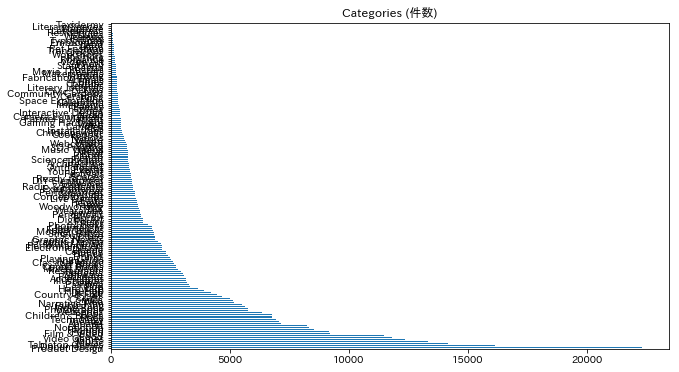

In [24]:
df_ksp["category"].value_counts().plot(kind="barh", figsize=(10,6), title="Categories (件数)")

## 3.2.4.2 category毎の成功率

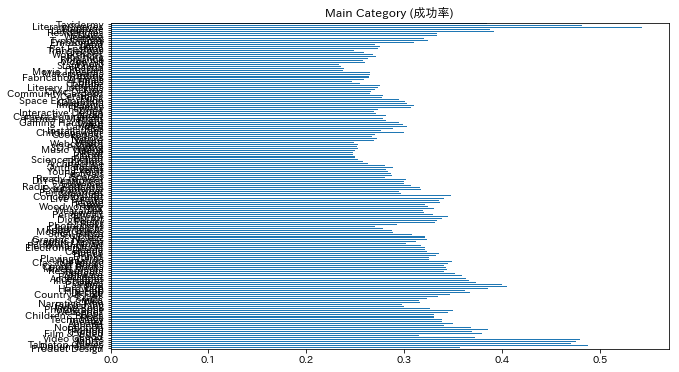

In [25]:
# 成功率
successful = df_ksp.loc[df_ksp["state"]]

pd.Series(successful["category"].value_counts().values / df_ksp["category"].value_counts().values,
         index=df_ksp["category"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Main Category (成功率)")

## 3.2.4.3 categoryを削除(drop)

In [26]:
df_ksp.drop(columns="category", inplace=True)
df_ksp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 12 columns):
main_category       374860 non-null object
currency            374860 non-null object
deadline            374860 non-null datetime64[ns]
goal                374860 non-null float64
launched            374860 non-null datetime64[ns]
pledged             374860 non-null float64
state               374860 non-null bool
backers             374860 non-null int64
country             374860 non-null object
usd pledged         374860 non-null float64
usd_pledged_real    374860 non-null float64
usd_goal_real       374860 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(5), int64(1), object(3)
memory usage: 34.7+ MB


## 3.2.5 項目 main_category (主なカテゴリー)
(1) 内容は、kickstarterプロジェクトの主なカテゴリーは15種類。  
(2) 成功率が高いはComics、Fashion、Film&Video、Crafs、Musicの順。  
(3) 失敗率が高いのは、Journalism。

In [27]:
# 項目 main_category の概要確認
df_ksp["main_category"].nunique()

15

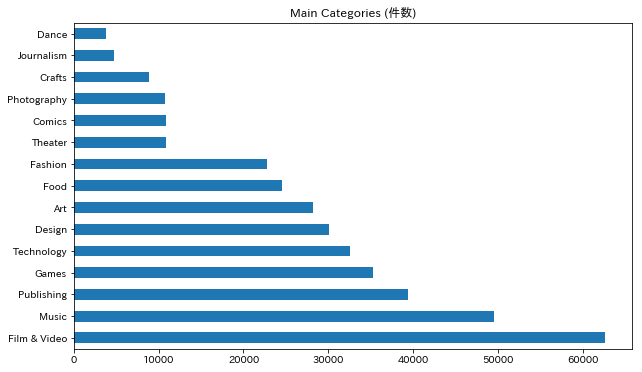

In [28]:
df_ksp["main_category"].value_counts().plot(kind="barh", figsize=(10,6), title="Main Categories (件数)")

## 3.2.5.1 main_category毎の成功率

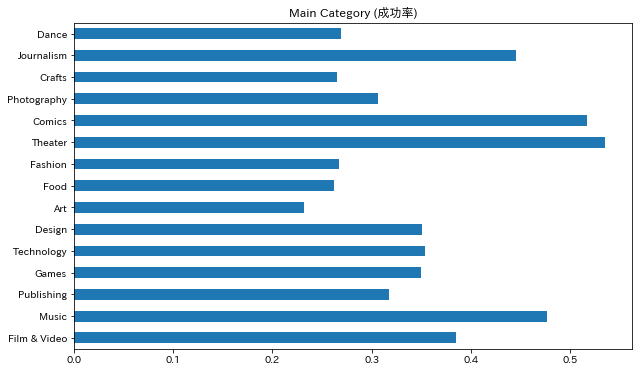

In [29]:
# 成功率
successful = df_ksp.loc[df_ksp["state"]]

pd.Series(successful["main_category"].value_counts().values / df_ksp["main_category"].value_counts().values,
         index=df_ksp["main_category"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Main Category (成功率)")

## 3.2.5.2 main_category毎の失敗率

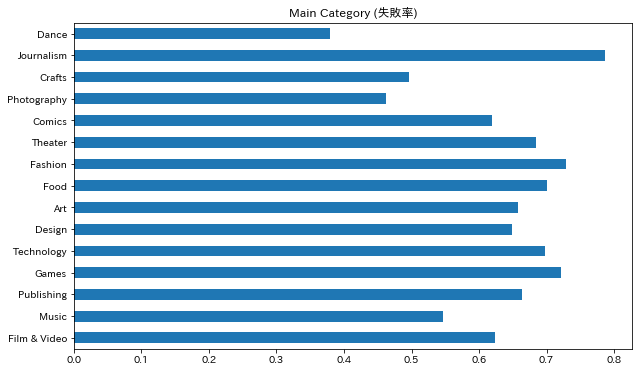

In [30]:
# 失敗率
failed = df_ksp.loc[~df_ksp["state"]]


pd.Series(failed["main_category"].value_counts().values / df_ksp["main_category"].value_counts().values,
         index=df_ksp["main_category"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Main Category (失敗率)")

## 3.2.6 項目 currency (使用された通貨)
(1) 使用された通貨は78%が米ドルである。日本円は0.01%である。  
(2) 成功率は、米国$と英国ポンドが高い(30%台後半)。日本円が低い(10%台後半)。  
(3) 失敗率は、日本円が高い(80%台前半)。米国$と英国ボンドが低い(60％台前半)。  

In [31]:
# 項目 currency の概要確認
df_ksp["currency"].nunique()

14

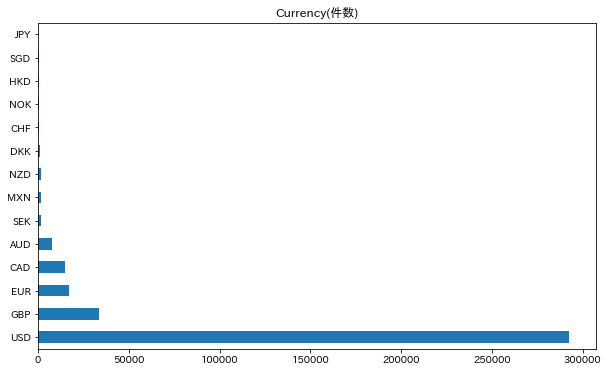

In [32]:
df_ksp["currency"].value_counts().plot(kind="barh", figsize=(10,6), title="Currency(件数)")

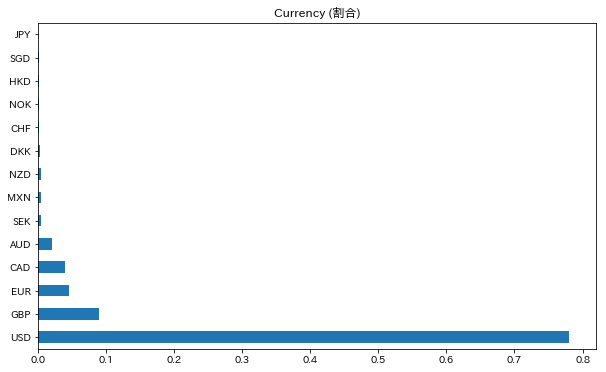

In [33]:
pd.Series(df_ksp["currency"].value_counts().values / df_ksp["currency"].value_counts().values.sum(),
         index=df_ksp["currency"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Currency (割合)")

In [34]:
df_ksp["currency"].value_counts()

USD    292624
GBP     33671
EUR     17219
CAD     14756
AUD      7839
SEK      1757
MXN      1752
NZD      1447
DKK      1113
CHF       761
NOK       708
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [35]:
pd.Series(df_ksp["currency"].value_counts().values / df_ksp["currency"].value_counts().values.sum(),
         index=df_ksp["currency"].value_counts().index)

USD    0.780622
GBP    0.089823
EUR    0.045934
CAD    0.039364
AUD    0.020912
SEK    0.004687
MXN    0.004674
NZD    0.003860
DKK    0.002969
CHF    0.002030
NOK    0.001889
HKD    0.001649
SGD    0.001481
JPY    0.000107
dtype: float64

## 3.2.6.1 currency毎の成功率

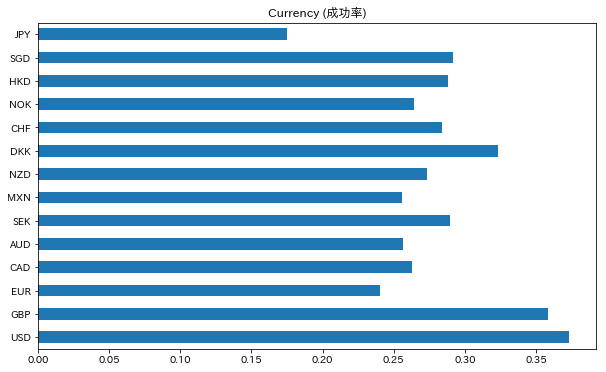

In [36]:
# 成功率
successful = df_ksp.loc[df_ksp["state"]]

pd.Series(successful["currency"].value_counts().values / df_ksp["currency"].value_counts().values,
         index=df_ksp["currency"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Currency (成功率)")

In [37]:
pd.Series(successful["currency"].value_counts().values / df_ksp["currency"].value_counts().values,
         index=df_ksp["currency"].value_counts().index)

USD    0.373513
GBP    0.358380
EUR    0.240084
CAD    0.262808
AUD    0.256410
SEK    0.289698
MXN    0.255708
NZD    0.273670
DKK    0.323450
CHF    0.283837
NOK    0.264124
HKD    0.288026
SGD    0.291892
JPY    0.175000
dtype: float64

## 3.2.6.2 currency毎の失敗率

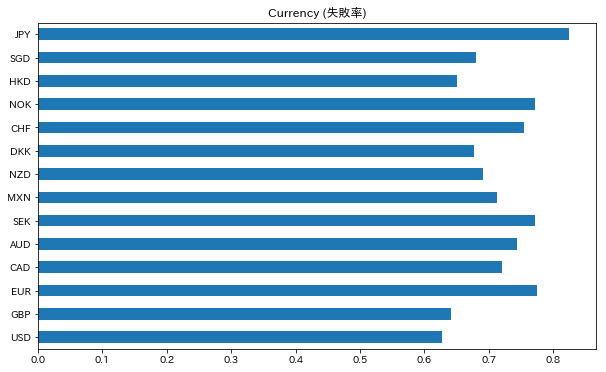

In [38]:
# 失敗率
failed = df_ksp.loc[~df_ksp["state"]]


pd.Series(failed["currency"].value_counts().values / df_ksp["currency"].value_counts().values,
         index=df_ksp["currency"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Currency (失敗率)")

In [39]:
pd.Series(failed["currency"].value_counts().values / df_ksp["currency"].value_counts().values,
         index=df_ksp["currency"].value_counts().index)

USD    0.626487
GBP    0.641620
EUR    0.774784
CAD    0.719843
AUD    0.743590
SEK    0.771770
MXN    0.712329
NZD    0.690394
DKK    0.676550
CHF    0.754271
NOK    0.771186
HKD    0.650485
SGD    0.679279
JPY    0.825000
dtype: float64

## 3.2.7 項目 deadline (資金調達の締切日付)
(1) 内容は、kickstarterプロジェクトの締切の日付である。  
(2) 9年間約3300日の期間に3164種類の日付が存在し、数が多いため検討の対象外とする。

In [40]:
# 項目 deadline の概要確認
df_ksp["deadline"].nunique()

3164

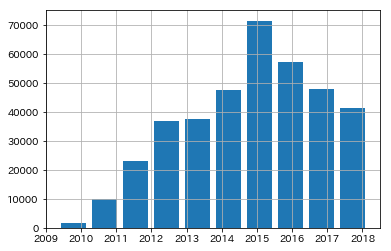

In [41]:
df_ksp["deadline"].hist(rwidth=.8)

## 3.2.8 項目 goal (目標金額)
(1) 内容は、kickstarterプロジェクトの目標金額である。
(2) 中央値5,500、75%値1.65e4に対して、最大値1e8は、75%値の6,060倍と極端に大きな値である。
(3) 「ハンペル判別法」により外れ値を除外した。

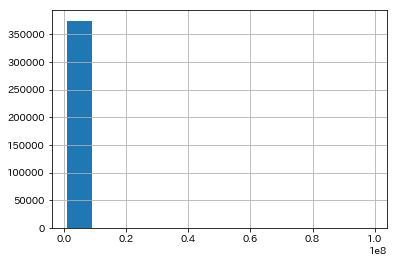

In [42]:
# 項目 goal の概要確認
df_ksp["goal"].hist(rwidth=.8)

In [43]:
df_ksp["goal"].describe()

count    3.748600e+05
mean     4.952299e+04
std      1.189362e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.650000e+04
max      1.000000e+08
Name: goal, dtype: float64

## 3.2.8.1 ハンペル判別法による外れ値の除外

In [44]:
med = df_ksp["goal"].median()
MAD = 1.4826 * np.median(abs(df_ksp["goal"] - med))
df_ksp = df_ksp[(med - 3 * MAD < df_ksp["goal"]) & (df_ksp["goal"] < med + 3 * MAD)]

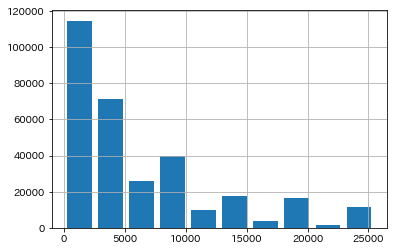

In [45]:
df_ksp["goal"].hist(rwidth=.8)

In [46]:
df_ksp["goal"].describe()

count    312656.000000
mean       6582.483331
std        6505.440181
min           0.010000
25%        1500.000000
50%        4800.000000
75%       10000.000000
max       25500.000000
Name: goal, dtype: float64

## 3.2.9 項目 launched (資金調達の開始日時)
(1) 内容は、kickstarterプロジェクトの発売日付である。  
(2) stateとの関係は、無いと考えるが、要確認。

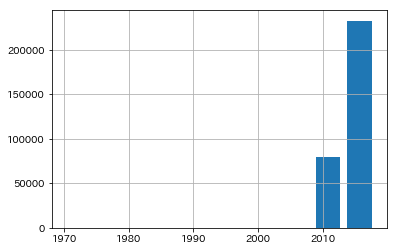

In [47]:
# 項目 launched の概要確認
df_ksp["launched"].hist(rwidth=.8)

In [48]:
df_ksp["launched"].describe()

count                  312656
unique                 312277
top       1970-01-01 01:00:00
freq                        7
first     1970-01-01 01:00:00
last      2018-01-02 15:02:31
Name: launched, dtype: object

## 3.2.9.1 項目launchedから1970-01-01を取り除く

In [49]:
df_ksp = df_ksp[df_ksp["launched"] > dt.datetime(1970, 1, 2)]

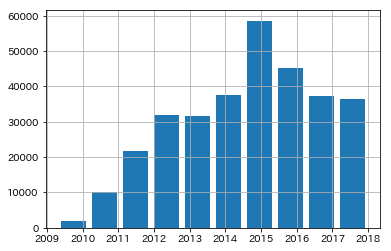

In [50]:
df_ksp["launched"].hist(rwidth=.8)

In [51]:
df_ksp["launched"].describe()

count                  312649
unique                 312276
top       2013-08-20 19:48:58
freq                        2
first     2009-04-21 21:02:48
last      2018-01-02 15:02:31
Name: launched, dtype: object

## 3.2.9.1 項目 period(募集期間) = deadline(締切日付) - launched(開始日時)

In [52]:
df_ksp["period"] = (df_ksp["deadline"] - df_ksp["launched"]).dt.days.astype(float)

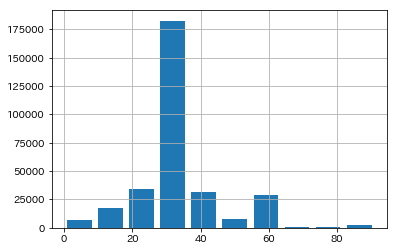

In [53]:
df_ksp["period"].hist(rwidth=.8)

In [54]:
df_ksp["period"].describe()

count    312649.000000
mean         32.591436
std          12.816596
min           0.000000
25%          29.000000
50%          29.000000
75%          34.000000
max          91.000000
Name: period, dtype: float64

## 3.2.9.2 成功した場合のperiodの分布

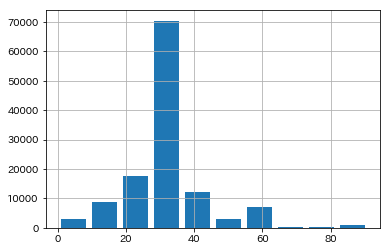

In [55]:
successful = df_ksp.loc[df_ksp["state"]]

successful["period"].hist(rwidth=.8)

## 3.2.9.3 失敗した場合のperiodの分布

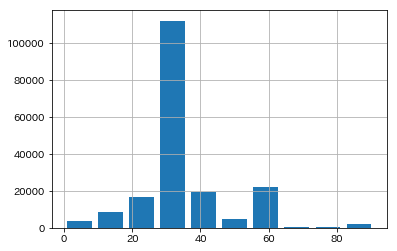

In [56]:
fatal = df_ksp.loc[~df_ksp["state"]]

fatal["period"].hist(rwidth=.8)

## 3.2.9.4 datetime変数 (deadlineとlaunched) の削除

In [57]:
df_ksp = df_ksp.drop(["deadline"], axis=1)
df_ksp = df_ksp.drop(["launched"], axis=1)
df_ksp.head()

,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,Publishing,GBP,1000.0,0.0,False,0,GB,0.0,0.0,1533.95,58.0
3,Music,USD,5000.0,1.0,False,1,US,1.0,1.0,5000.00,29.0
4,Film & Video,USD,19500.0,1283.0,False,14,US,1283.0,1283.0,19500.00,55.0
6,Food,USD,1000.0,1205.0,True,16,US,1205.0,1205.0,1000.00,19.0
7,Food,USD,25000.0,453.0,False,40,US,453.0,453.0,25000.00,44.0


## 3.2.10 項目 pledged (集まった金額)
(1) 内容は、kickstarterプロジェクトの種類である。

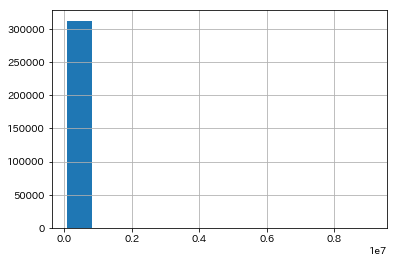

In [58]:
# 項目 pledged の概要確認
df_ksp["pledged"].hist(rwidth=.8)

In [59]:
df_ksp["pledged"].describe()

count    3.126490e+05
mean     4.970275e+03
std      3.845400e+04
min      0.000000e+00
25%      3.500000e+01
50%      6.100100e+02
75%      3.573000e+03
max      9.192056e+06
Name: pledged, dtype: float64

## 3.2.10.1 ハンペル判別法による外れ値の除去

In [60]:
med = df_ksp["pledged"].median()
MAD = 1.4826 * np.median(abs(df_ksp["pledged"] - med))
df_ksp = df_ksp[(med - 3 * MAD < df_ksp["pledged"]) & (df_ksp["pledged"] < med + 3 * MAD)]

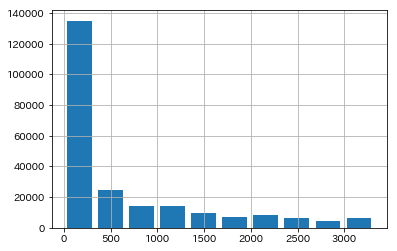

In [61]:
df_ksp["pledged"].hist(rwidth=.8)

In [62]:
df_ksp["pledged"].describe()

count    230973.000000
mean        623.178165
std         864.357055
min           0.000000
25%          10.000000
50%         173.000000
75%         970.000000
max        3323.000000
Name: pledged, dtype: float64

## 3.2.11 項目 backers (集まった支援者)
(1) 内容は、

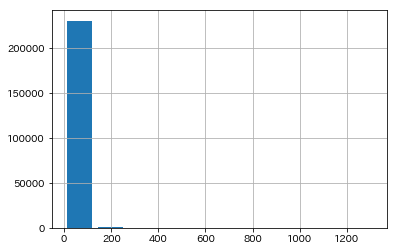

In [63]:
# 項目 backers の概要確認
df_ksp["backers"].hist(rwidth=.8)

## 3.2.11.1 ハンペル判別法による外れ値の除去

In [64]:
med = df_ksp["backers"].median()
MAD = 1.4826 * np.median(abs(df_ksp["backers"] - med))
df_ksp = df_ksp[(med - 3 * MAD < df_ksp["backers"]) & (df_ksp["backers"] < med + 3 * MAD)]

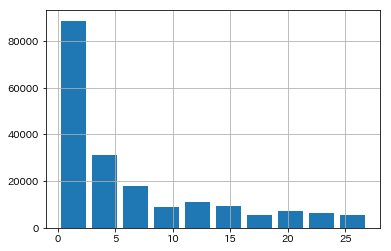

In [65]:
df_ksp["backers"].hist(rwidth=.8)

## 3.2.12 項目 country (プロジェクトが開かれた国)
(1) 一位の米国が78%、二位の英国が9%。  


In [66]:
# 項目 country の概要確認
df_ksp["country"].nunique()

21

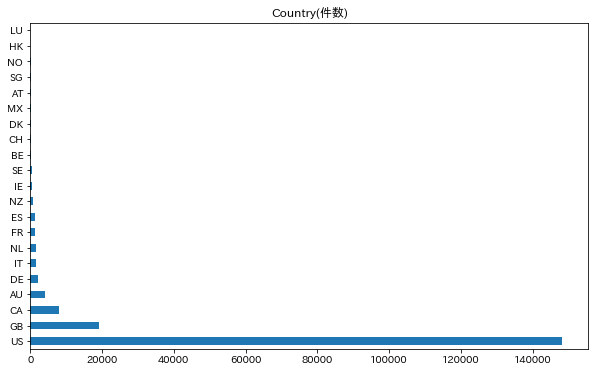

In [67]:
df_ksp["country"].value_counts().plot(kind="barh", figsize=(10,6), title="Country(件数)")

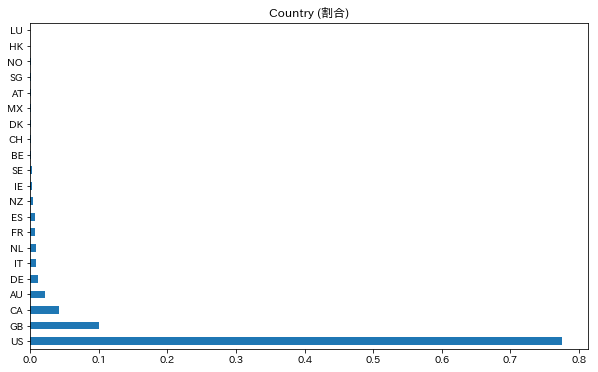

In [68]:
pd.Series(df_ksp["country"].value_counts().values / df_ksp["country"].value_counts().values.sum(),
         index=df_ksp["country"].value_counts().index).plot(
    kind="barh", figsize=(10,6), title="Country (割合)")

In [69]:
df_ksp["country"].value_counts()

US    148051
GB     19158
CA      7908
AU      4202
DE      2185
IT      1610
NL      1581
FR      1419
ES      1250
NZ       757
IE       447
SE       405
BE       354
CH       330
DK       305
MX       303
AT       302
SG       237
NO       188
HK        78
LU        26
Name: country, dtype: int64

In [70]:
pd.Series(df_ksp["country"].value_counts().values / df_ksp["country"].value_counts().values.sum(),
         index=df_ksp["country"].value_counts().index)

US    0.774747
GB    0.100253
CA    0.041382
AU    0.021989
DE    0.011434
IT    0.008425
NL    0.008273
FR    0.007426
ES    0.006541
NZ    0.003961
IE    0.002339
SE    0.002119
BE    0.001852
CH    0.001727
DK    0.001596
MX    0.001586
AT    0.001580
SG    0.001240
NO    0.000984
HK    0.000408
LU    0.000136
dtype: float64

## 3.2.13 項目 usd pledged (集まった資金の米ドル換算)
(1) 内容は、

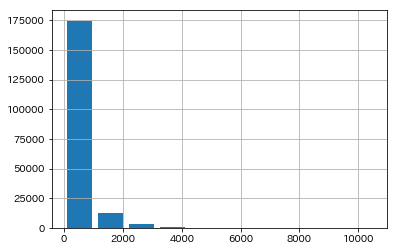

In [71]:
# 項目 usd pledged の概要確認
df_ksp["usd pledged"].hist(rwidth=.8)

## 3.2.13.1 ハンペル判別法による外れ値の除去

In [72]:
med = df_ksp["usd pledged"].median()
MAD = 1.4826 * np.median(abs(df_ksp["usd pledged"] - med))
df_ksp = df_ksp[(med - 3 * MAD < df_ksp["usd pledged"]) & (df_ksp["usd pledged"] < med + 3 * MAD)]

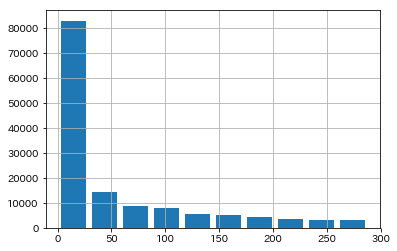

In [73]:
df_ksp["usd pledged"].hist(rwidth=.8)

In [74]:
df_ksp["usd pledged"].describe()

count    137861.000000
mean         50.696374
std          73.435059
min           0.000000
25%           0.000000
50%          10.000000
75%          77.680000
max         288.620000
Name: usd pledged, dtype: float64

## 3.2.14 項目 usd_pledged_real (集まった資金・realとは?)
(1) 内容は、

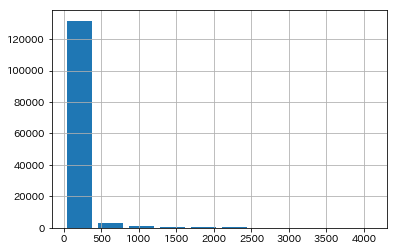

In [75]:
# 項目 usd_pledged_real の概要確認
df_ksp["usd_pledged_real"].hist(rwidth=.8)

## 3.2.14.1 ハンペル判別法による外れ値の除去

In [76]:
med = df_ksp["usd_pledged_real"].median()
MAD = 1.4826 * np.median(abs(df_ksp["usd_pledged_real"] - med))
df_ksp = df_ksp[(med - 3 * MAD < df_ksp["usd_pledged_real"]) & (df_ksp["usd_pledged_real"] < med + 3 * MAD)]

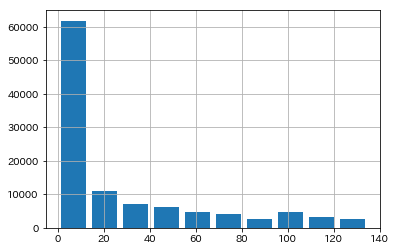

In [77]:
df_ksp["usd_pledged_real"].hist(rwidth=.8)

In [78]:
df_ksp["usd_pledged_real"].describe()

count    108182.000000
mean         26.461721
std          36.623557
min           0.000000
25%           0.000000
50%           5.000000
75%          45.000000
max         134.990000
Name: usd_pledged_real, dtype: float64

## 3.2.15 項目 usd_goal_real (目標金額の米ドル換算・realとは?)
(1) 内容は、

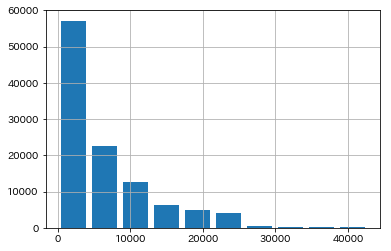

In [79]:
# 項目 usd_goal_real の概要確認
df_ksp["usd_goal_real"].hist(rwidth=.8)

In [80]:
df_ksp["usd_goal_real"].describe()

count    108182.000000
mean       6151.901938
std        6698.633606
min           0.010000
25%        1029.692500
50%        3779.290000
75%        9700.000000
max       42800.160000
Name: usd_goal_real, dtype: float64

## 4 数値項目間の関係

## 4.1 要約統計量

In [81]:
df_ksp.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,period
count,108182.000000,108182.000000,108182.000000,108182.000000,108182.000000,108182.000000,108182.000000
mean,6069.730183,27.855521,1.501479,23.081134,26.461721,6151.901938,33.282413
std,6456.161208,55.044598,1.956434,35.074208,36.623557,6698.633606,13.747106
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,1000.000000,0.000000,0.000000,0.000000,0.000000,1029.692500,29.000000
50%,4000.000000,5.000000,1.000000,1.070000,5.000000,3779.290000,29.000000
75%,10000.000000,44.000000,2.000000,35.000000,45.000000,9700.000000,36.000000
max,25500.000000,2447.000000,27.000000,265.000000,134.990000,42800.160000,91.000000


## 4.2 相関係数

## 4.2.1 散布図行列 (pandas)

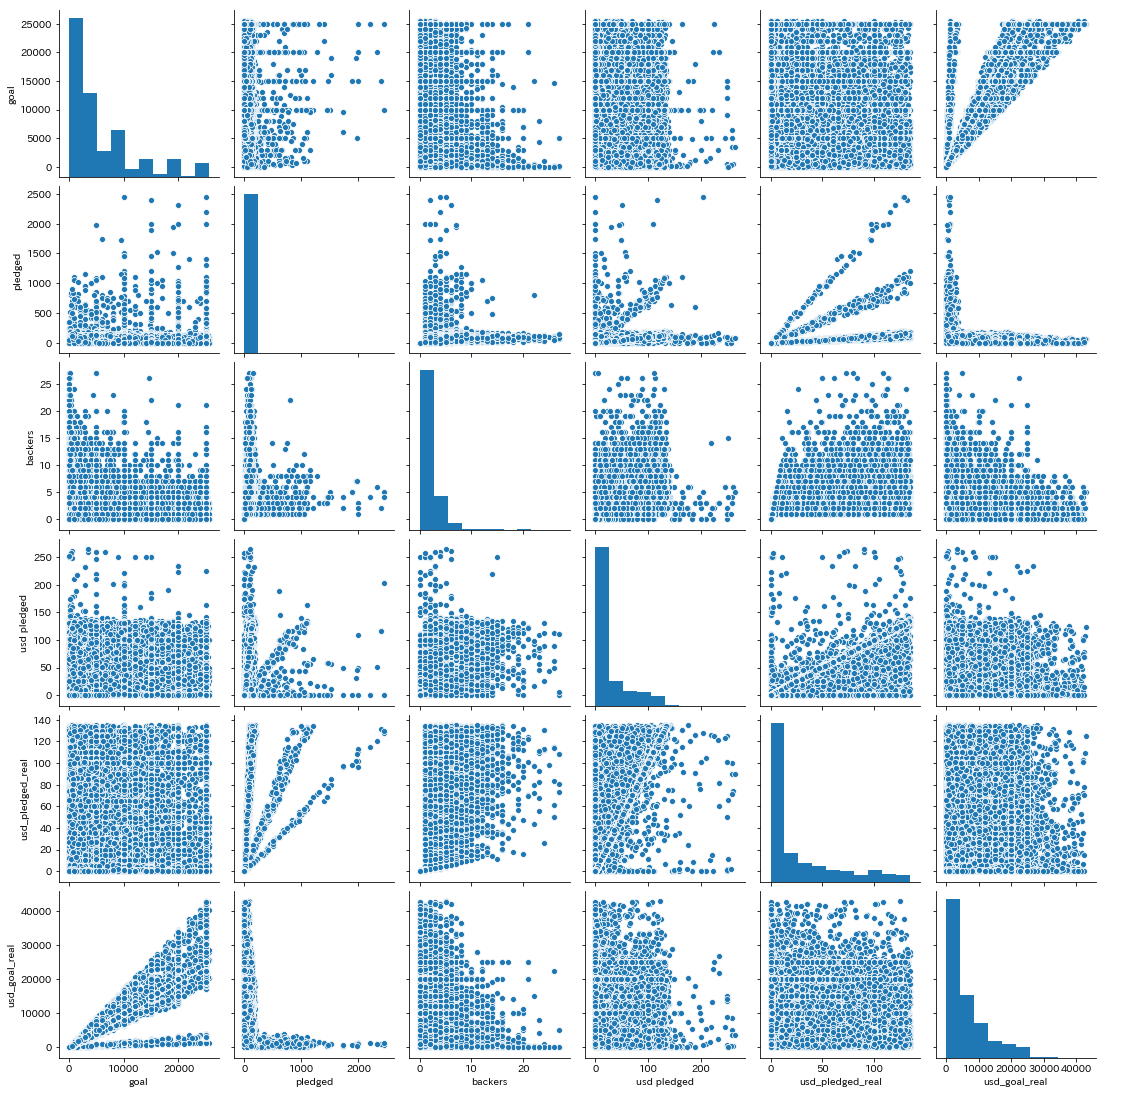

In [82]:
# 散布図行列を書いてみる
sns.pairplot(df_ksp[["goal", "pledged", "backers", 
             "usd pledged", "usd_pledged_real", "usd_goal_real"]])

## 4.2.2 相関係数 (pandas)

In [83]:
# 相関係数を確認
df_ksp.corr()

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
goal,1.000000,0.020775,-0.110646,-0.061208,-0.023915,-0.022160,0.964585,0.115774
pledged,0.020775,1.000000,0.093365,0.484433,0.607928,0.696145,-0.043362,0.009240
state,-0.110646,0.093365,1.000000,0.213850,0.109270,0.126657,-0.108166,-0.061670
backers,-0.061208,0.484433,0.213850,1.000000,0.612163,0.677744,-0.061841,-0.006118
usd pledged,-0.023915,0.607928,0.109270,0.612163,1.000000,0.903478,-0.020001,0.023490
usd_pledged_real,-0.022160,0.696145,0.126657,0.677744,0.903478,1.000000,-0.021696,0.016795
usd_goal_real,0.964585,-0.043362,-0.108166,-0.061841,-0.020001,-0.021696,1.000000,0.110503
period,0.115774,0.009240,-0.061670,-0.006118,0.023490,0.016795,0.110503,1.000000


## 4.3 ヒートマップ
- なぜか、表示されないことがある。

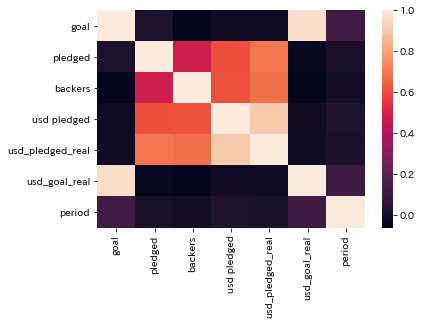

In [84]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ksp[["goal", "pledged", "backers", 
             "usd pledged", "usd_pledged_real", "usd_goal_real", "period"]].corr(), xticklabels=True, yticklabels=True)
plt.show()

## 5. stateと数値項目の関係
(1) 以下の組み合わせは線形分離できるが、②～⑥はプロジェクト完了後に得られる情報であるため、成功する/しないの予測には使えない。
- ①goal と ②pledged
- ①goal と ③backers
- ①goal と ④usd pledged
- ①goal と ⑤usd_predged_real
- ①goal と ⑥usd_goal_real
- ①goal と ⑦priod
- ⑥usd_goal_real と ②pledged
- ⑥usd_goal_real と ③backers
- ⑥usd_goal_real と ④usd pledged  
- ⑥usd_goal_real と ⑤usd_pledged_real
- ⑥usd_goal_real と ⑦priod

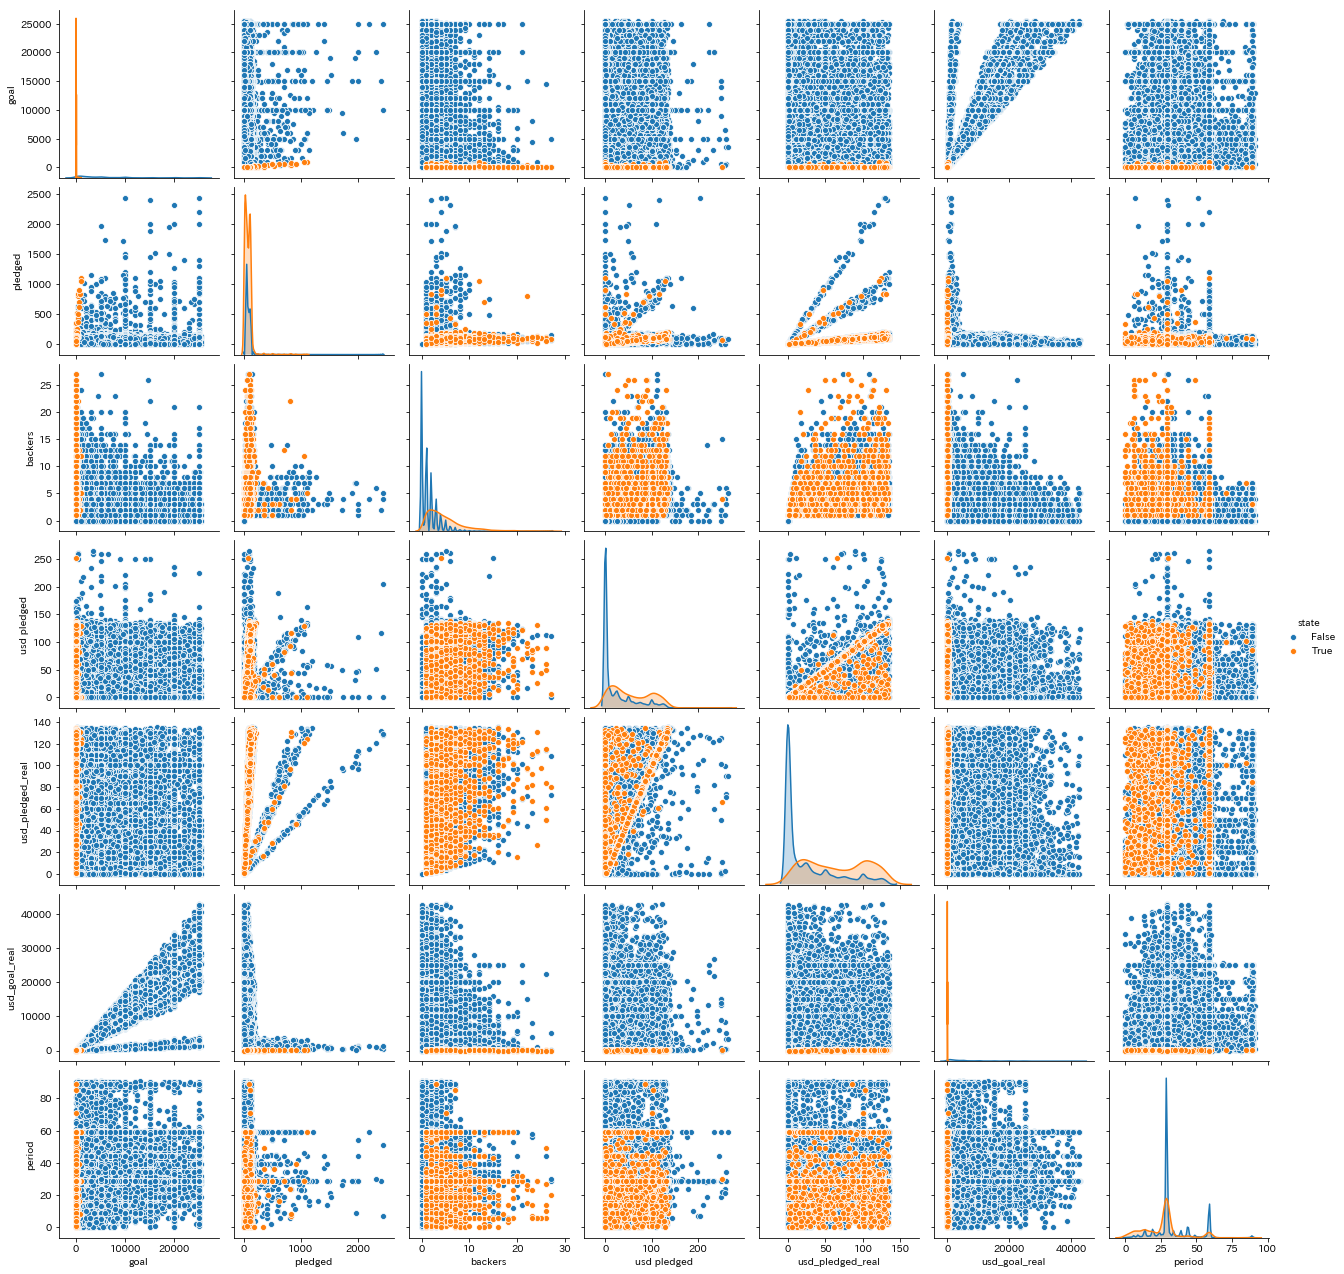

In [85]:
sns.pairplot(df_ksp[["state", "goal", "pledged", "backers", "usd pledged", 
                      "usd_pledged_real", "usd_goal_real", "period"]], hue="state")

## 6. ダミー変数化

## 6.1 main_category

In [86]:
df_dummy = pd.get_dummies(df_ksp["main_category"])
df_ksp = pd.concat([df_ksp.drop(["main_category"], axis=1), df_dummy], axis=1)

In [87]:
df_ksp.head()

,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,GBP,1000.0,0.0,False,0,GB,0.0,0.00,1533.95,58.0,...,0,0,0,0,0,0,0,1,0,0
3,USD,5000.0,1.0,False,1,US,1.0,1.00,5000.00,29.0,...,0,0,0,0,0,1,0,0,0,0
10,CAD,2500.0,0.0,False,0,CA,0.0,0.00,2406.39,29.0,...,0,0,0,0,0,0,0,1,0,0
12,USD,5000.0,0.0,False,0,US,0.0,0.00,5000.00,29.0,...,0,0,0,0,0,0,0,0,0,0
21,AUD,2500.0,1.0,False,1,AU,0.0,0.81,2026.10,29.0,...,1,0,0,0,0,0,0,0,0,0


## 6.2 currency

In [88]:
df_dummy = pd.get_dummies(df_ksp["currency"])
df_ksp = pd.concat([df_ksp.drop(["currency"], axis=1), df_dummy], axis=1)

In [89]:
df_ksp.head()

,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,Art,...,DKK,EUR,GBP,HKD,MXN,NOK,NZD,SEK,SGD,USD
0,1000.0,0.0,False,0,GB,0.0,0.00,1533.95,58.0,0,...,0,0,1,0,0,0,0,0,0,0
3,5000.0,1.0,False,1,US,1.0,1.00,5000.00,29.0,0,...,0,0,0,0,0,0,0,0,0,1
10,2500.0,0.0,False,0,CA,0.0,0.00,2406.39,29.0,0,...,0,0,0,0,0,0,0,0,0,0
12,5000.0,0.0,False,0,US,0.0,0.00,5000.00,29.0,0,...,0,0,0,0,0,0,0,0,0,1
21,2500.0,1.0,False,1,AU,0.0,0.81,2026.10,29.0,0,...,0,0,0,0,0,0,0,0,0,0


## 6.3 country

In [90]:
df_dummy = pd.get_dummies(df_ksp["country"])
df_ksp = pd.concat([df_ksp.drop(["country"], axis=1), df_dummy], axis=1)

In [91]:
df_ksp.head()

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,Art,Comics,...,IE,IT,LU,MX,NL,NO,NZ,SE,SG,US
0,1000.0,0.0,False,0,0.0,0.00,1533.95,58.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5000.0,1.0,False,1,1.0,1.00,5000.00,29.0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,2500.0,0.0,False,0,0.0,0.00,2406.39,29.0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,5000.0,0.0,False,0,0.0,0.00,5000.00,29.0,0,0,...,0,0,0,0,0,0,0,0,0,1
21,2500.0,1.0,False,1,0.0,0.81,2026.10,29.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 7. ロジスティック回帰

## 7.1 項目5の②～⑥を含めたロジスティック回帰

In [92]:
X = df_ksp.drop("state", axis=1).values
y = df_ksp["state"].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, 
                    fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, '.format(w0, w1, w2), end="")
print('w3 = {:.3f}, w4 = {:.3f}'.format(w3, w4))
print('w5 = {:.3f}, w6 = {:.3f}'.format(w5, w6))

w0 = 206.455, w1 = -31784.223, w2 = 30836.734, w3 = 1512.783, w4 = 16036.237
w5 = 26915.679, w6 = -36187.223


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [93]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)), end="")

# 正答率を表示
print(' 正答率(accuracy)={:.3f}%  recall={:.3f}%  precision={:.3f}%'.format(
    100 * accuracy_score(y, y_est), 
    100 * recall_score(y, y_est), 
    100 * precision_score(y, y_est)))

対数尤度 = -0.094 正答率(accuracy)=99.728%  recall=94.737%  precision=86.866%


In [94]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = リノベーションなし', '正解 = リノベーション済み'], 
                        columns=['予測 = リノベーションなし', '予測 = リノベーション済み'])
conf_mat

,予測 = リノベーションなし,予測 = リノベーション済み
正解 = リノベーションなし,106466,215
正解 = リノベーション済み,79,1422


## 7.2 項目5の②～⑥を除いたロジスティック回帰

In [95]:
df_ksp = df_ksp.drop(["pledged"], axis=1)
df_ksp = df_ksp.drop(["backers"], axis=1)
df_ksp = df_ksp.drop(["usd pledged"], axis=1)
df_ksp = df_ksp.drop(["usd_pledged_real"], axis=1)
df_ksp = df_ksp.drop(["usd_goal_real"], axis=1)

In [96]:
df_ksp.head()

,goal,state,period,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,IE,IT,LU,MX,NL,NO,NZ,SE,SG,US
0,1000.0,False,58.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5000.0,False,29.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,2500.0,False,29.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,5000.0,False,29.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21,2500.0,False,29.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
X = df_ksp.drop("state", axis=1).values
y = df_ksp["state"].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, 
                    fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, '.format(w0, w1, w2), end="")
print('w3 = {:.3f}, w4 = {:.3f}'.format(w3, w4))
print('w5 = {:.3f}, w6 = {:.3f}'.format(w5, w6))

w0 = 375.625, w1 = -5.711, w2 = -20.634, w3 = 114.267, w4 = 23.883
w5 = 55.933, w6 = 0.654


In [98]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)), end="")

# 正答率を表示
print(' 正答率(accuracy)={:.3f}%  recall={:.3f}%  precision={:.3f}%'.format(
    100 * accuracy_score(y, y_est), 
    100 * recall_score(y, y_est), 
    100 * precision_score(y, y_est)))

対数尤度 = -0.582 正答率(accuracy)=98.316%  recall=54.763%  precision=41.832%


In [99]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = リノベーションなし', '正解 = リノベーション済み'], 
                        columns=['予測 = リノベーションなし', '予測 = リノベーション済み'])
conf_mat

,予測 = リノベーションなし,予測 = リノベーション済み
正解 = リノベーションなし,105538,1143
正解 = リノベーション済み,679,822
